### Loading of Images

In [1]:
from pathlib import Path
import imghdr
import os
from PIL import Image

data_dir = "hair_types"
image_extensions = [".bmp", ".gif", ".png", ".jpg", ".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
        # else:
        #     img = Image.open(filepath).convert('L')
        #     img.save(filepath)

/var/folders/_2/9tdd0_v908qf2_1bw_19j5wr0000gn/T/ipykernel_51101/3690981329.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


### Hyperparameters

In [2]:
epochs = 50
img_dimensions = (64, 64)
batch_size = 32
learning_rate = 1e-3

### Preprocessing

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    validation_split=0.2,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

train_ds = datagen.flow_from_directory(
    data_dir,
    subset="training",
    seed=1337,
    target_size=img_dimensions,
    batch_size=batch_size,
    shuffle=True,
)

val_ds = datagen.flow_from_directory(
    data_dir,
    subset="validation",
    seed=1337,
    target_size=img_dimensions,
    batch_size=batch_size, 
    shuffle=True,
)

Found 788 images belonging to 3 classes.
Found 196 images belonging to 3 classes.


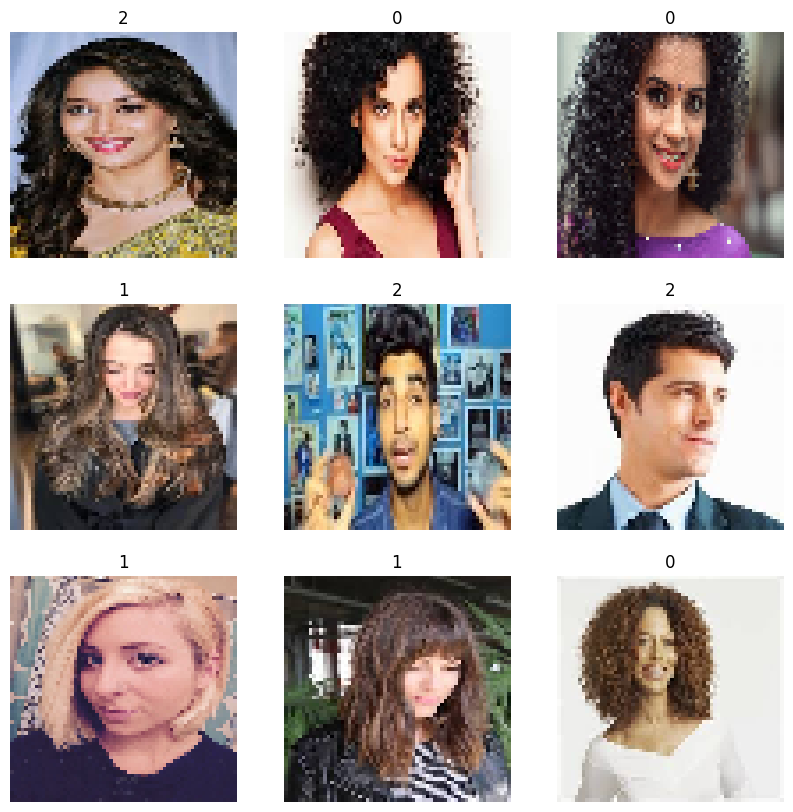

In [4]:
# looking at some sample images
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
images, labels = next(train_ds)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(int(np.argmax(labels[i])))
    plt.axis("off")
plt.show()

### Modelling

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
import pydot as pydot

model = Sequential()
model.add(keras.Input(shape=img_dimensions + (3,))) 

#Normalization
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=4, kernel_size=16, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=8, kernel_size=8, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(64))
model.add(layers.Activation("relu"))
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 49, 49, 4)      │         3,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 49, 49, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 17, 8)      │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 17, 17, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 16)       │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,479 (33.12 KB)

 Trainable params: 8,479 (33.12 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [6]:
def learning_rate_schedule(epoch):
    initial_lr = learning_rate
    drop = 0.1
    epochs_drop = 12
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                                tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)
                                ]
                    )

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.3323 - loss: 1.1036 - val_accuracy: 0.3980 - val_loss: 1.0900 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.3939 - loss: 1.0818 - val_accuracy: 0.4745 - val_loss: 1.0526 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.4472 - loss: 1.0446 - val_accuracy: 0.4184 - val_loss: 1.0517 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.4950 - loss: 1.0271 - val_accuracy: 0.4337 - val_loss: 1.0308 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.4876 - loss: 1.0169 - val_accuracy: 0.4388 - val_loss: 1.0212 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.4875 - loss: 0.9936 - val_accuracy: 0.4337 - val_loss: 1.0188 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.5072 - loss: 0.9591 - val_accurac

### Visualization 

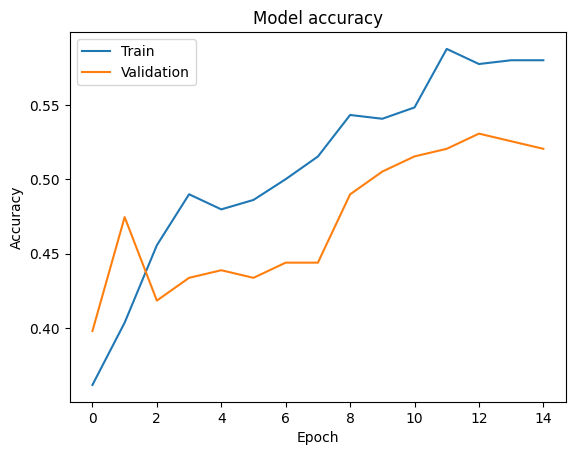

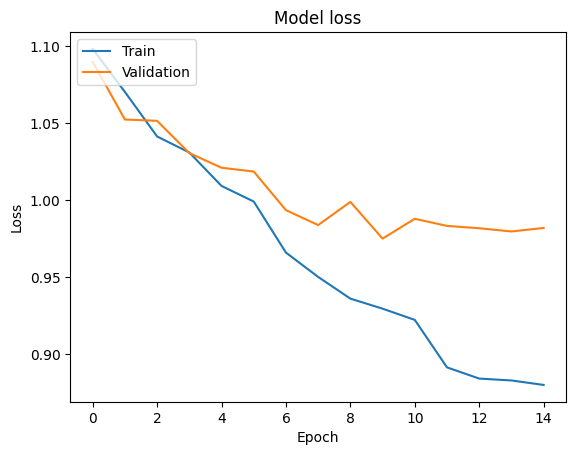

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Sample Prediction

In [8]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=img_dimensions
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
This image is 0.65 percent curly hair, 0.30 percent straight hair, and 0.05 percent wavy hair.


In [9]:
# Print the last epoch's performance results
print("Training Loss:", history.history['loss'][-1])
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Loss:", history.history['val_loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5031 - loss: 1.0094
Validation Loss: 0.9821115732192993
Validation Accuracy: 0.5204081535339355
